In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
max_date = session.query(func.max(Measurement.date)).first()
max_date


('2017-08-23',)

Text(0, 0.5, 'Inches')

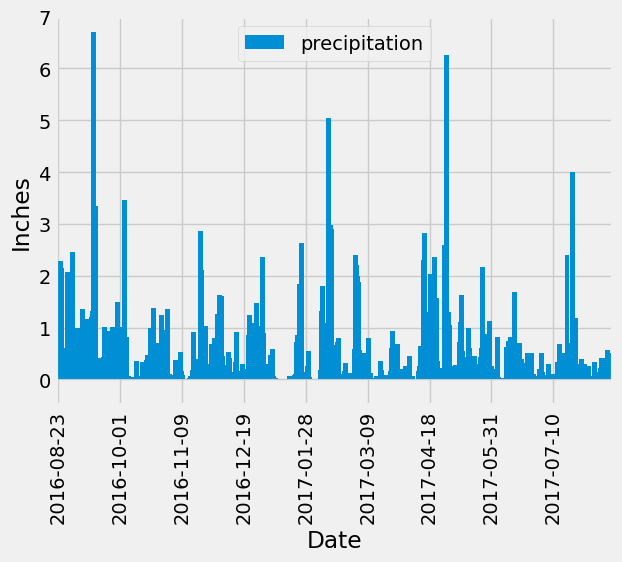

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
end_date = dt.datetime.strptime(max_date[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
start_date = end_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
precip_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date.between(start_date, end_date))

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_query, columns=['date', 'precipitation'])

# Sort the dataframe by date
precip_sorted_df = precip_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_sorted_df.plot(kind="bar", x="date", y="precipitation", width=20)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.ylim((-.5, 7))
plt.xlabel('Date')
plt.ylabel('Inches')


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_sorted_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(Measurement.station).distinct().count()

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(
    Measurement.station, 
    func.count(Measurement.station)
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:

# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(
    func.min(Measurement.tobs), 
    func.max(Measurement.tobs), 
    func.avg(Measurement.tobs)
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()

(54.0, 85.0, 71.66378066378067)

Text(0.5, 0, 'Temperature')

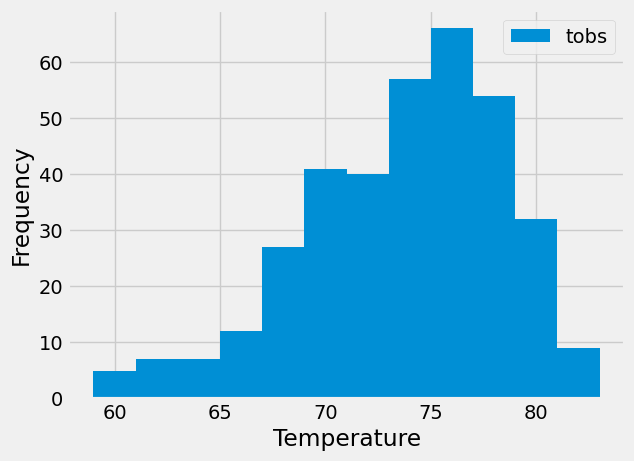

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Get the most active station
most_active_station_id = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()

# Get the latest observation date and convert it to a datetime object
end_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station_id[0]).group_by(Measurement.station).first()
end_date = dt.datetime.strptime(end_date[0], '%Y-%m-%d')

# Calculate one year in the past
start_date = end_date - dt.timedelta(days=366)

# Get the temperature observations for the given station and date range
temp_query = session.query(Measurement.tobs).filter(Measurement.station == most_active_station_id[0], Measurement.date.between(start_date, end_date))

# Plot the data in a histogram with 12 bins
temp_df = pd.DataFrame(temp_query)
temp_df.plot(kind="hist", bins=12)
plt.xlabel('Temperature')

# Close Session

In [16]:
# Close Session
session.close()